In [1]:
import os
%pwd

'/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/HIV_inhibitors_classification_and_generation/research'

In [2]:
os.chdir("../")
%pwd

'/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/HIV_inhibitors_classification_and_generation'

In [3]:
from dataclasses import dataclass
from pathlib import Path
from typing import List

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    model_folder_path: Path
    source_root: Path
    processed_root: Path
    source_filename: Path
    processed_filename: List[str]
    params: dict

In [17]:
from hivclass.constants import *
from hivclass.utils.main_utils import create_directories, read_yaml

class ConfigurationManager:
    def __init__(
        self,
        config_file_path = CONFIG_FILE_PATH,
        params_file_path = PARAMS_FILE_PATH,
        schema_file_path = SCHEMA_FILE_PATH
    ):
        self.config = read_yaml(config_file_path)
        self.params = read_yaml(params_file_path)
        self.schema = read_yaml(schema_file_path)
        
        create_directories([self.config.artifacts_root])
    
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation
        params = self.params.BEST_PARAMETERS
        
        create_directories([config.root_dir])
        
        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            model_folder_path=config.model_folder_path,
            source_root=config.source_root,
            processed_root=config.processed_root,
            source_filename=config.source_filename,
            processed_filename=config.processed_filename,
            params=params
        )
        
        return model_evaluation_config

In [15]:
from hivclass.utils.molecule_dataset import MoleculeDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from hivclass.utils.molecule_dataset import MoleculeDataset
from hivclass.utils.mol_gnn import MolGNN
import os
from hivclass.utils.main_utils import save_json, plot_confusion_matrix, plot_roc_curve
import torch 
from torch_geometric.data import DataLoader
from box import ConfigBox
import sys
from tqdm import tqdm

class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config
    
    def dataset_preparation(self):
        test_dataset = MoleculeDataset(
            source_root=self.config.source_root,
            processed_root=self.config.processed_root,
            source_filename=self.config.source_filename,
            procesed_filename=self.config.processed_filename,
            test=True
        )
        
        test_loader = DataLoader(test_dataset, batch_size=self.config.params['batch_size'])
        
        return test_dataset, test_loader
    
    def model_preparation(self, dataset, device):
        params = self.config.params
        params['model_edge_dim'] = dataset[0].edge_attr.shape[1]
        model_params = ConfigBox({k: v for k, v in params.items() if k.startswith("model_")})
        
        model = MolGNN(feature_size=dataset[0].x.shape[1], model_params=model_params).to(device)
        
        model_path = os.path.join(
            self.config.model_folder_path,
            os.listdir(self.config.model_folder_path)[0]
        )
        
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device))
            print(f"Model loaded from {model_path}")
        else:
            raise FileNotFoundError(f"Model file {model_path} not found")
        
        return model
    
    def testing(self, test_loader, model, device):
        model.eval()
        test_preds = []
        test_labels = []
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(test_loader)):
                batch = batch.to(device)
                
                preds = model(batch.x.float(), batch.edge_attr.float(), batch.edge_index, batch.batch)
                test_preds.extend(torch.round(torch.squeeze(preds)).cpu().detach().numpy())
                test_labels.extend(batch.y.cpu().detach().numpy())
                
                accuracy = accuracy_score(test_labels, test_preds)
                
                sys.stdout.write(
                    "Batch:%2d/%2d - test_accuracy:%.4f" %(
                        i,
                        len(test_loader),
                        accuracy
                    )
                )
                sys.stdout.flush()
        
        return test_preds, test_labels
    
    def evaluation(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("device:", device)
        
        test_dataset, test_loader = self.dataset_preparation()
        
        model = self.model_preparation(test_dataset, device)
        
        test_preds, test_labels = self.testing(test_loader, model, device)
        
        report = classification_report(
                    test_labels,
                    test_preds,
                    zero_division=0,
                    output_dict=True
                )

        save_json(
            os.path.join(self.config.root_dir, f'report.json'),
            report
        )

        conf_matrix = confusion_matrix(test_labels, test_preds)

        plot_confusion_matrix(
            conf_matrix,
            self.config.root_dir,
            'test'
        )

        auc_score = roc_auc_score(test_labels, test_labels)
        auc_score_dict = {'auc_score': auc_score}

        save_json(
            os.path.join(self.config.root_dir, f'auc_score.json'), 
            auc_score_dict
        )
        
        plot_roc_curve(
            test_labels,
            test_preds,
            self.config.root_dir,
            'test'
        )

[2025-04-20 16:51:24,060: INFO: main_utils: created directory at: artifacts]
[2025-04-20 16:51:24,062: INFO: main_utils: created directory at: artifacts/model_evaluation]


/mnt/cb03386d-9344-47b1-82f9-868fbb64b4ae/python_projects/HIV_inhibitors_classification_and_generation/env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


device: cuda
Model loaded from artifacts/model_trainer/models/best_params/model_0.pth


0it [00:00, ?it/s]

Batch: 0/ 3 - test_accuracy:0.4727

1it [00:00,  1.38it/s]

Batch: 1/ 3 - test_accuracy:0.4980

2it [00:01,  1.30it/s]

Batch: 2/ 3 - test_accuracy:0.5017

3it [00:01,  1.69it/s]

[2025-04-20 16:51:25,919: INFO: main_utils: json file saved at: artifacts/model_evaluation/report.json]
[2025-04-20 16:51:26,073: INFO: main_utils: json file saved at: artifacts/model_evaluation/auc_score.json]


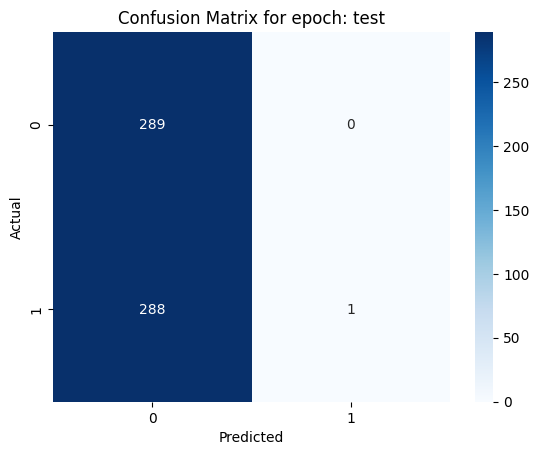

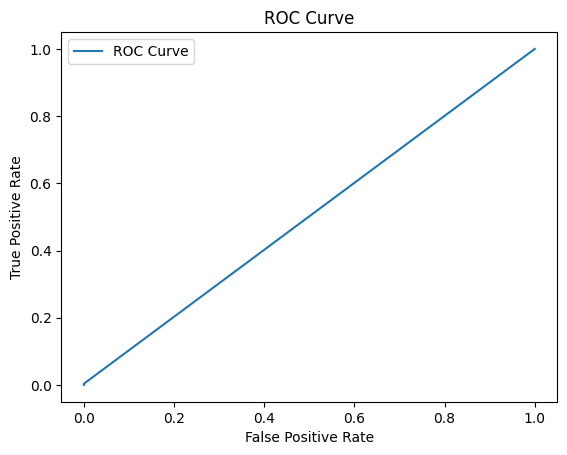

In [16]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)
    model_evaluation.evaluation()

except Exception as e:
    raise e